# 📓ISIC 2019 – Data Preparation & Image Engineering

This notebook documents the **data cleaning, preprocessing, verification, and image engineering pipeline** used for the ISIC 2019 skin lesion dataset. The goal is to transform raw ISIC images and labels into a **clean, standardized, and model-ready dataset** suitable for TensorFlow and PyTorch training.

---

In [12]:
import os
import sys

# Get the current directory of this script
current_dir = os.path.dirname(os.path.abspath("__file__"))
# Add the parent directory to Python path
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

import pandas as pd
from PIL import Image
from tqdm import tqdm
from data_cleaning.paths import DATA, RAW_DATA, RAW_IMGS, PROCESSED_IMGS, WORKED_IMGS


## 📊 1. Dataset Overview

The ISIC 2019 dataset contains dermoscopic images labeled across multiple skin lesion classes. Labels are provided in a **one-hot encoded CSV file**, while images are stored as JPEG files.

**Classes used (9 total):**

* MEL (Melanoma)
* NV (Melanocytic Nevus)
* BCC (Basal Cell Carcinoma)
* AK (Actinic Keratosis)
* BKL (Benign Keratosis-like Lesions)
* DF (Dermatofibroma)
* VASC (Vascular Lesions)
* SCC (Squamous Cell Carcinoma)
* UNK (Unknown)


In [3]:
df = pd.read_csv(os.path.join(RAW_DATA, "ISIC_2019_Training_GroundTruth.csv"))

# Class columns in order
class_cols = ["MEL","NV","BCC","AK","BKL","DF","VASC","SCC","UNK"]

---
## 🔖 2. Label Processing

The original CSV contains one-hot encoded columns for each class. To simplify training:

* The dominant class per image is extracted using `idxmax`
* Each class name is mapped to a numeric label (`label_idx`)

This enables compatibility with:

* `SparseCategoricalCrossentropy` (TensorFlow)
* `CrossEntropyLoss` (PyTorch)

**Outcome:**
Each image now has:

* `label_name` → human-readable class
* `label_idx` → integer class ID

In [4]:
# Determine label column for one-hot encoding
df["label_name"] = df[class_cols].idxmax(axis=1)

# Map label_name -> integer class
class_to_idx = {c:i for i,c in enumerate(class_cols)}
df["label_idx"] = df["label_name"].map(class_to_idx)

---

## 📷 3. Image Resizing & Standardization

### Motivation

Raw ISIC images vary significantly in resolution and size, leading to:

* High disk usage (~9GB)
* Inconsistent input shapes
* Increased GPU memory usage

### Approach

* All images are resized to **512 × 512**
* Images are explicitly converted to **RGB (3 channels)**
* Saved as JPEG with quality = 90 to balance size and fidelity

In [5]:
# Resize Images to reduce dataset size
target_size = (512,512)                 # or 244x244 for fast training

bad_images = []
processed_imgs = os.path.join(DATA, "processed/images")

for img_name in tqdm(df["image"]):
    src_path = os.path.join(RAW_IMGS, f"{img_name}.jpg")
    dst_path = os.path.join(processed_imgs, f"{img_name}.jpg")
    # Skip if already resized
    if os.path.exists(dst_path):
        continue

    try:
        img = Image.open(src_path)
        img = img.convert("RGB")    # ensure 3 channels
        img = img.resize(target_size, Image.BILINEAR) # type: ignore
        # img.save(dst_path, "JPEG", quality=90)      # To save the resized image
    except Exception as e:
        bad_images.append((img_name, str(e)))

print("Corrupted Images: ", bad_images)

100%|██████████| 25331/25331 [00:02<00:00, 11685.96it/s]

Corrupted Images:  []



### Benefits

* Reduced dataset size
* Fixed input shape for CNNs
* Avoids grayscale / channel-mismatch errors

Corrupted or unreadable images are logged and excluded.

---

## 🎯 4. Dataset Verification & EDA

Before model training, the processed dataset is validated.

### 4.1 File Integrity Checks

* Verify each image file exists
* Detect corrupted images using `PIL.Image.verify()`
* Remove missing or corrupted samples from the dataset

This ensures training stability and avoids runtime crashes.

In [6]:
# Verify all resized images 
df["image_path"] = df["image"].apply(lambda x: os.path.join(PROCESSED_IMGS, f"{x}.jpg"))

df["exists"] = df["image_path"].apply(os.path.exists)

missing = df[df["exists"] == False]
print("Missing images:", len(missing))
missing.head()

# Check for corrupted images
corrupted = []

for p in tqdm(df["image_path"]):
    try:
        img = Image.open(p)
        img.verify()        # verify integrity
    except:
        corrupted.append(p)

print("Corrupted images: ", corrupted)

# If images corrupted
df = df[~df["image_path"].isin(corrupted)]
df = df[df["exists"] == True]
df = df.reset_index(drop=True)

Missing images: 0


100%|██████████| 25331/25331 [00:28<00:00, 874.60it/s] 

Corrupted images:  []


---

### 4.2 Class Distribution Analysis

A bar plot is generated to visualize class imbalance, which is a known characteristic of ISIC datasets.

This analysis informs:

* Loss weighting
* Sampling strategies
* Evaluation interpretation

label_name
NV      12875
MEL      4522
BCC      3323
BKL      2624
AK        867
SCC       628
VASC      253
DF        239
Name: count, dtype: int64


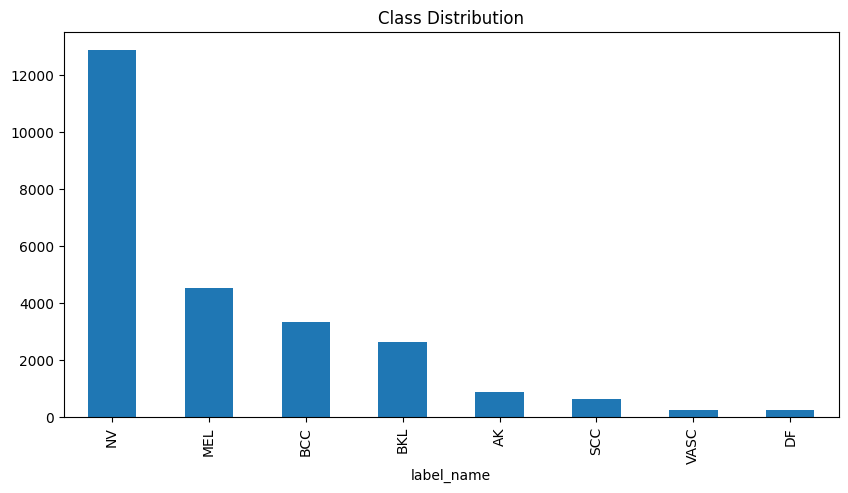

In [7]:
import matplotlib.pyplot as plt
# Class distribution
class_counts = df["label_name"].value_counts()

print(class_counts)
class_counts.plot(kind="bar", title="Class Distribution", figsize=(10,5))
plt.show()

---

### 4.3 Visual Sanity Check

For each class, random samples are displayed to:

* Confirm correct labels
* Inspect visual diversity
* Identify artifacts or preprocessing issues

This step is crucial for trust in the data pipeline.

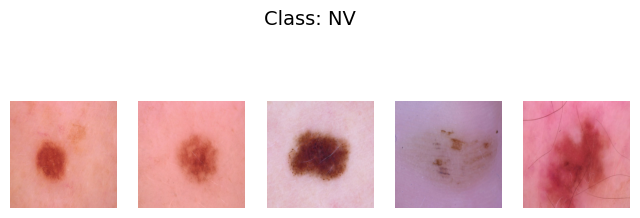

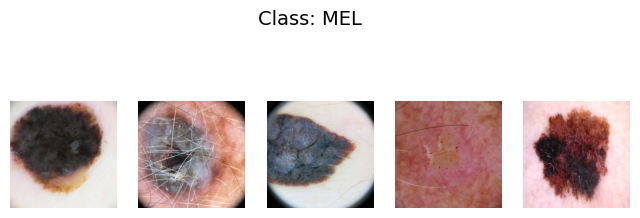

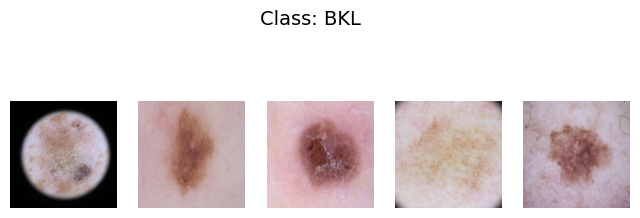

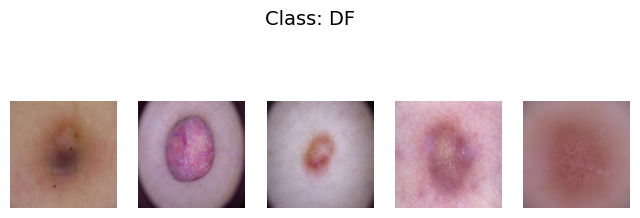

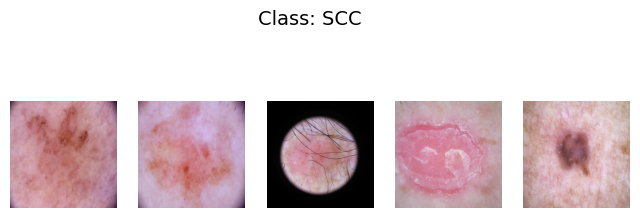

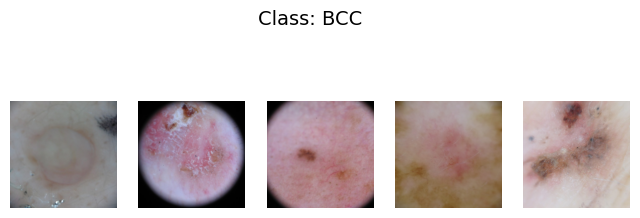

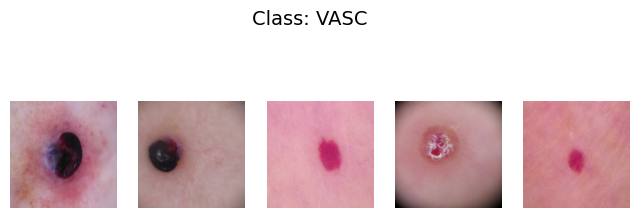

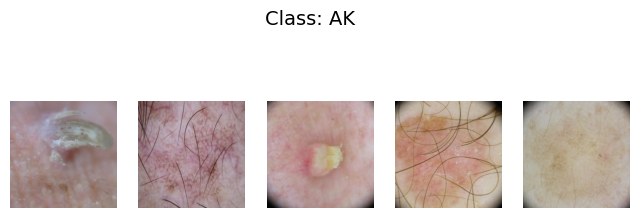

In [8]:
# Sample images per class
classes = df["label_name"].unique()

for c in classes:
    samples = df[df["label_name"] == c].sample(5)["image_path"].values

    plt.figure(figsize=(8,3))
    plt.suptitle(f"Class: {c}", fontsize=14)

    for i, path in enumerate(samples):
        img = Image.open(path)
        plt.subplot(1,5,i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.show()

---

### 4.4 Image Shape Statistics

Image dimensions are collected across the dataset to confirm:

* Minimum size
* Maximum size
* Mean size

After resizing, all images converge to a consistent resolution, validating the preprocessing stage.

In [9]:
import numpy as np
# Collect image properties
shapes = []

for p in tqdm(df["image_path"]):
    img = Image.open(p)
    shapes.append(img.size)

shapes = np.array(shapes)

print("Min size: ", shapes.min(axis=0))
print("Max size: ", shapes.max(axis=0))
print("Mean size: ", shapes.mean(axis=0))

100%|██████████| 25331/25331 [00:07<00:00, 3566.02it/s]

Min size:  [512 512]
Max size:  [512 512]
Mean size:  [512. 512.]


---

## 📝 5. Image Engineering (Medical-Specific Enhancements)

To improve lesion visibility and reduce noise, two domain-specific techniques are applied.

---

### 5.1 CLAHE (Contrast Limited Adaptive Histogram Equalization)

**Purpose:**

* Enhance local contrast
* Improve visibility of subtle lesion structures

**Method:**

* Convert RGB → LAB color space
* Apply CLAHE on the luminance channel (L)
* Recombine channels and convert back to RGB

This improves feature clarity without amplifying noise.


In [10]:
import cv2
# CLAHE - improve local contrast
def apply_clahe_rgb(img):
    """Apply CLAHE to RGB image - expects numpy array in RGB format"""
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))

    return cv2.cvtColor(limg, cv2.COLOR_Lab2RGB)


---

### 5.2 Hair Removal via Morphological Processing

**Problem:**
Hair occlusions introduce strong visual noise that can mislead CNNs.

**Solution:**

* Convert image to grayscale
* Use black-hat morphology to detect thin dark lines (hair)
* Threshold and dilate the hair mask
* Inpaint affected regions using Telea’s algorithm

In [11]:
# Hair removal - detect dark thin lines and inpaint
def remove_hairs(img_rgb):
    """Remove hairs from RGB image - expects numpy array in RGB format"""
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    # Black-hat to find hair-like structures
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17,17))
    blackhat = cv2.morphologyEx(img_gray, cv2.MORPH_BLACKHAT, kernel)
    # Threshold the blackhat
    _, mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    # Dilate mask a bit
    mask = cv2.dilate(mask, np.ones((3,3), np.uint8), iterations=1)
    # Inpaint the RGB image
    inpainted = cv2.inpaint(img_rgb, mask, 3, cv2.INPAINT_TELEA)
    return inpainted

In [13]:
for img_name in tqdm(df["image"]):
        src_path = os.path.join(PROCESSED_IMGS, f"{img_name}.jpg")
        dst_path = os.path.join(WORKED_IMGS, f"{img_name}.jpg")
        # Skip if already resized
        if os.path.exists(dst_path):
            continue
        try:
            # Read with OpenCV
            img_bgr = cv2.imread(src_path)
            if img_bgr is None:
                print(f"Could not read image: {src_path}")
                continue
                
            # Convert BGR to RGB for processing
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            
            # Apply processing
            img_processed = apply_clahe_rgb(img_rgb)
            img_processed = remove_hairs(img_processed)
            
            # Convert back to BGR for saving with OpenCV
            img_processed_bgr = cv2.cvtColor(img_processed, cv2.COLOR_RGB2BGR)
            # cv2.imwrite(dst_path, img_processed_bgr, [cv2.IMWRITE_JPEG_QUALITY, 90]) to save the file

        except Exception as e:
            print(f"Error processing: {img_name}", e)

100%|██████████| 25331/25331 [00:01<00:00, 15680.46it/s]


**Result:**

* Cleaner lesion regions
* Reduced spurious edges
* Improved model focus on skin patterns

---

## ✅ 6. Final Output Structure

After the full pipeline, the dataset consists of:

* `processed/images/` → resized RGB images
* `worked/images/` → CLAHE + hair-removed images
* Cleaned CSV with:

  * image name
  * label_name
  * label_idx

This structure is compatible with both:

* TensorFlow `ImageDataGenerator` / `tf.data`
* PyTorch `Dataset` + `DataLoader`



---

## 7. Key Takeaways

* All images are standardized to RGB and fixed resolution
* Corrupted and missing samples are safely removed
* Medical image-specific enhancements improve signal quality
* The pipeline is reproducible, modular, and framework-agnostic

This preprocessing stage lays a **robust foundation** for CNN training and downstream fine-tuning.

---
